In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from collections import Counter

import numpy as np
import pandas as pd
import pickle
import random
import os

torch.manual_seed(10)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

In [5]:
model = BiLSTM(20)
#model.to(device)
#model = BiLSTM(17)


# Class weights (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
#weights = torch.tensor([0.69,2.95,0.08,0.02,0.77,0.017,18.59,0 ,0.007,76.83], dtype=torch.float32)
#weights = weights / weights.sum()
#weights = 1.0 / weights
#weights = weights / weights.sum()


#loss_function = nn.NLLLoss()
#loss_function = nn.CrossEntropyLoss(weight=weights.to(device))
loss_function = nn.CrossEntropyLoss()
#loss_function = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.003)

In [4]:
# A common headache in this competition is the lack of determinism in the results due to cudnn, the following solves the issue
def seed_everything(seed=10):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# Do not run this block

In [6]:
def process_vision_output():
    i = 1
    for file in os.scandir('./vision_output'):
        if (os.path.isfile('./nlp_output/{0}'.format(file.name))):
            vision_out = []
            with open(file, "rb") as openfile:
                while True:
                    try:
                        vision_out.append(pickle.load(openfile))
                    except EOFError:
                        break

            processed_out = []

            for idk in vision_out:
                for segment in idk:
                    vector = segment[1]
                    for word in segment[0].split(' '):
                        processed_out.append([word, vector])

            processed_out = processed_out
            with open("./processed_vision_output/{0}".format(file.name), 'wb') as f:
                pickle.dump(processed_out, f)
            print("File {0}".format(i), end='\r')
            i+=1

# Do not run this block

In [7]:
process_vision_output()

# Do not run this block

In [24]:
def process_input():
    i=1
    for nlp_file in os.scandir('./nlp_output'):
        if not os.path.isfile("./processed_vision_output/{0}".format(nlp_file.name)):
            continue
        with open(nlp_file, "rb") as f:
            nlp_out = pickle.load(f)

        with open("./processed_vision_output/{0}".format(nlp_file.name), "rb") as f:
            vision_out = pickle.load(f)
        nlp_out = np.reshape(nlp_out, (int(nlp_out.shape[0]/2), -1))
        

        combined_out = []
        clone_nlp_out = np.copy(nlp_out)
        for word in vision_out:
            if word[0] != '':
                match_indexes = np.where(clone_nlp_out == word[0])
                if len(match_indexes[0]) == 0:
                    continue
                match_words = clone_nlp_out[match_indexes[0][0]]
                if match_words.shape[0] > 0:
                    word_string = match_words[0]
                    word_vector = match_words[1]

                    combined_out.append([word_string, word_vector, word[1]])
                    print(combined_out)
                    break
                    clone_nlp_out = np.delete(clone_nlp_out, match_indexes[0][0], axis=0)
        
        break
        #with open("./input/{0}".format(nlp_file.name), 'wb') as f:
            #pickle.dump(combined_out, f)
            #i+=1
            #print(i, end='\r')
    print("finished {0} files".format(i))

# Do not run this block

In [25]:
process_input()

[['LILOG-DB:', array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1.0121e-05, 1.3362e-05, 1.6208e-05, 3.9565e-05, 2.9993e-05, 9.6917e-06,
        1.5591e-05, 7.7356e-05, 9.9926e-01, 5.3165e-04], device='cuda:0')]]
finished 1 files


<ipython-input-24-df703234343e>:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  match_indexes = np.where(clone_nlp_out == word[0])


In [28]:
with open("./input/11258_1341.pickle", "rb") as f:
    vision_out = pickle.load(f)
    print(vision_out)

[['Racial', array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]), tensor([2.0732e-05, 1.5546e-04, 3.6291e-05, 6.5662e-05, 9.9903e-01, 3.6597e-05,
        1.9442e-05, 6.5046e-05, 1.5049e-04, 4.1674e-04], device='cuda:0')], ['Enhanced', array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1.7972e-04, 6.9671e-05, 2.3943e-04, 4.3705e-04, 2.2131e-04, 4.9830e-05,
        6.1091e-05, 1.7892e-04, 9.9815e-01, 4.1133e-04], device='cuda:0')], ['plant', array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1.7972e-04, 6.9671e-05, 2.3943e-04, 4.3705e-04, 2.2131e-04, 4.9830e-05,
        6.1091e-05, 1.7892e-04, 9.9815e-01, 4.1133e-04], device='cuda:0')], ['fault', array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1.7972e-04, 6.9671e-05, 2.3943e-04, 4.3705e-04, 2.2131e-04, 4.9830e-05,
        6.1091e-05, 1.7892e-04, 9.9815e-01, 4.1133e-04], device='cuda:0')], ['diagnosis', array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor([1.7972e-04, 6.9671e-05, 2.3943e-04, 4.3705e-04, 2.2131e-04, 4.98

In [40]:
vectors = []
labels = []
words = []

for file in os.scandir('./input'):
    with open(file, 'rb') as f:
        vs = pickle.load(f)
    
    for w in vs:
        
        words.append(w[0])
        temp_w = w[2].cpu()
        temp_t = temp_w.numpy()
        vectors.append(np.concatenate((temp_t, w[1])))
        labels.append(np.argmax(w[1]))
    
vectors = np.array(vectors)
labels = np.array(labels)

In [42]:
vectors.shape

(610439, 20)

In [43]:
vectors[1]

array([7.82922943e-05, 6.14503442e-05, 1.55886766e-04, 1.45714599e-04,
       2.01831383e-04, 3.60690901e-05, 4.54061919e-05, 1.10021567e-04,
       9.98981655e-01, 1.83759941e-04, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [44]:
labels.shape

(610439,)

In [45]:
x_train, x_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.2, random_state=42,stratify=labels)

In [46]:
x_train.shape

(488351, 20)

In [47]:
y_train.shape

(488351,)

In [48]:
x_test.shape

(122088, 20)

In [49]:
labels = torch.from_numpy(np.array(y_train, dtype=np.int64)).to(device)
v = torch.from_numpy(np.array(x_train, dtype=np.float64)).view(-1, 1, 20).float().to(device)
print(v.shape)
print(labels.shape)

torch.Size([488351, 1, 20])
torch.Size([488351])


In [50]:
labels_2 = torch.from_numpy(np.array(y_test, dtype=np.int64)).to(device)
v2 = torch.from_numpy(np.array(x_test, dtype=np.float64)).view(-1, 1, 20).float().to(device)
print(v2.shape)
print(labels_2.shape)

torch.Size([122088, 1, 20])
torch.Size([122088])


In [55]:
labels_2[1]

tensor(6)

In [56]:
x_train[1]

array([9.94781554e-01, 1.85067183e-04, 5.69579948e-04, 1.04696129e-03,
       1.74202723e-04, 3.27866292e-04, 1.80693227e-04, 1.15335826e-03,
       9.47981840e-04, 6.32654235e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [57]:
class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset = dataset
    def __getitem__(self,index):
        data,target = self.dataset[index]
        return data,target,index
    def __len__(self):
        return len(self.dataset)

In [66]:
train = MyDataset(torch.utils.data.TensorDataset(v, labels))
train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle=True)

test = MyDataset(torch.utils.data.TensorDataset(v2, labels_2))
test_loader = torch.utils.data.DataLoader(test, batch_size = 128, shuffle=True)

In [71]:
len(test_loader)

954

In [80]:
class BiLSTM(nn.Module): 
    # This NLP part Will consist of two bidirectional lstm layers and it's output is 
    # determined by the LSTM's last hidden states or output vectors.

    # This will take as an input a sequence of words and output the last hidden layer
    # the last hidden states of 2-layer bidirectional LSTM will be the input of the last multimodel network 

    def __init__(self, embedding_dim, hidden_dim = 256, layer_dim =2, output_dim = 10):
        super(BiLSTM, self).__init__()
        
        
        # Replace this when using GPU
        #self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = 'cpu'
        
        self.embedding_dim = embedding_dim
        
        #Hidden dimensions
        self.hidden_dim = hidden_dim # maybe set this to 256

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building the LSTM 
        # batch_first = True causes the input/output to be of shape 3D (batch_dim, seq_dim, feature_dim) 
        # output will be the same dim as the hidden dim
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        
        self.dropout = nn.Dropout(p=0.2)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
                
        # Initialize hidden state with zeros
        # self.layer_dim * 2. because we have one going forwards and another going backwards
        #h0 = torch.randn(self.layer_dim * 2, x.size(0), self.hidden_dim, device=self.device)
        h0 = torch.randn(self.layer_dim * 2, x.size(0), self.hidden_dim)
        
        
        
        # Initialize cell state
        #c0 =  torch.randn(self.layer_dim * 2, x.size(0), self.hidden_dim, device=self.device)
        c0 =  torch.randn(self.layer_dim * 2, x.size(0), self.hidden_dim)
        
        # We suppose we are conducting a 28 time steps In case of using 
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm1(x, (h0.detach(), c0.detach()))
        # out = self.fc(out.view(out.size(0), -1))
          
        # Without the activation function, out will contain the last hidden layer.
        # This could be obtianed from hn[-1] as well.
        out = out[:, -1, :]
        
        out = self.dropout(out)
        
        out = self.fc(out)
        
        
        return out
        
        # Index hidden state of last time step
        # out.size() --> 256, 100, 256 if we have (input dim = 100 and hidden dim = 100)
        # out[:, -1, :] => 256, 256 --> because we just want the last time step hidden states
        #out = out[:, -1, :] # without an activation function

        # now our: out.size() --> 256, 10 (if output dimension is equal to 10)
        #return out

In [84]:
model = BiLSTM(20)



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

# Training the model
batch_size = 128
epochs = 300
losses = []
validation_losses = []
min_loss = np.Inf

for epoch in range(epochs):
    
    train_loss = 0.0
    model.train()
    for i, (x_batch, y_batch, index) in enumerate(train_loader):
        optimizer.zero_grad()
        
        label_scores = model(x_batch)
        # Calculate loss, backpropagate, and update weights/parameters by calling opt.step()
        loss = criterion(label_scores, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*x_batch.size(0)
    
    train_loss = train_loss/len(train_loader.sampler)
    losses.append(train_loss)
    
    with torch.no_grad():
        val_loss = 0
        accuracy = 0
        model.eval()
        for x, y, i in test_loader:
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()*x.size(0)
            
            scores, classes = F.softmax(out, dim=1).topk(1, dim=1)
            equals = classes == y.view(*classes.shape)
            
            accuracy += torch.mean(equals.type(torch.FloatTensor))
            
        val_loss = val_loss/len(test_loader.sampler)
        accuracy = accuracy/len(test_loader)
            
    validation_losses.append(val_loss)
    print("Epoch: {0} | Training loss: {1} | Validation loss: {2} | Accuracy: \t{3:.2f}".format(epoch, train_loss, val_loss, accuracy))
    
    if (val_loss < min_loss):
        torch.save(model.state_dict(), "model_fixed_v1.pt")
        print("Loss decreased: {0} ==> {1}".format(min_loss, val_loss))
        min_loss = val_loss
    
print("Bi-LSTM model training is done!                           ", end='\r')
print("final labels {0}".format(label_scores))

Epoch: 0 | Training loss: 0.026181706111704367 | Validation loss: 0.0023265608950266085 | Accuracy: 	1.00
Loss decreased: inf ==> 0.0023265608950266085
Epoch: 1 | Training loss: 0.0014177623502812104 | Validation loss: 0.0008734723909996461 | Accuracy: 	1.00
Loss decreased: 0.0023265608950266085 ==> 0.0008734723909996461
Epoch: 2 | Training loss: 0.0012325049343457652 | Validation loss: 0.0009271577457463253 | Accuracy: 	1.00
Epoch: 3 | Training loss: 0.0011611079196989554 | Validation loss: 0.0007603225659541713 | Accuracy: 	1.00
Loss decreased: 0.0008734723909996461 ==> 0.0007603225659541713
Epoch: 4 | Training loss: 0.0013527928674159882 | Validation loss: 0.0006295835991884246 | Accuracy: 	1.00
Loss decreased: 0.0007603225659541713 ==> 0.0006295835991884246
Epoch: 5 | Training loss: 0.0010729187503587278 | Validation loss: 0.0010386237547610107 | Accuracy: 	1.00
Epoch: 6 | Training loss: 0.0012260115481817215 | Validation loss: 0.0012125206643060404 | Accuracy: 	1.00
Epoch: 7 | Tra

Epoch: 73 | Training loss: 0.0011239066900261942 | Validation loss: 0.00017161035257002113 | Accuracy: 	1.00
Loss decreased: 0.00020723291306254163 ==> 0.00017161035257002113
Epoch: 74 | Training loss: 0.0009780213689529335 | Validation loss: 0.0002735201206322085 | Accuracy: 	1.00
Epoch: 75 | Training loss: 0.0010437553369975101 | Validation loss: 0.0007498090972361447 | Accuracy: 	1.00
Epoch: 76 | Training loss: 0.0011295732956889534 | Validation loss: 0.0005200856886175248 | Accuracy: 	1.00
Epoch: 77 | Training loss: 0.0010049681002744118 | Validation loss: 0.0005379448357618973 | Accuracy: 	1.00
Epoch: 78 | Training loss: 0.0008826214021777965 | Validation loss: 0.0005658819214304766 | Accuracy: 	1.00
Epoch: 79 | Training loss: 0.0008552117953983181 | Validation loss: 0.0006589638375090363 | Accuracy: 	1.00
Epoch: 80 | Training loss: 0.0007645260116135712 | Validation loss: 0.00024232503597708128 | Accuracy: 	1.00
Epoch: 81 | Training loss: 0.0005323662215165068 | Validation loss: 

KeyboardInterrupt: 

In [86]:
torch.save(model, "FinalModelOverfit")

Text(0, 0.5, 'Cross Entropy Loss')

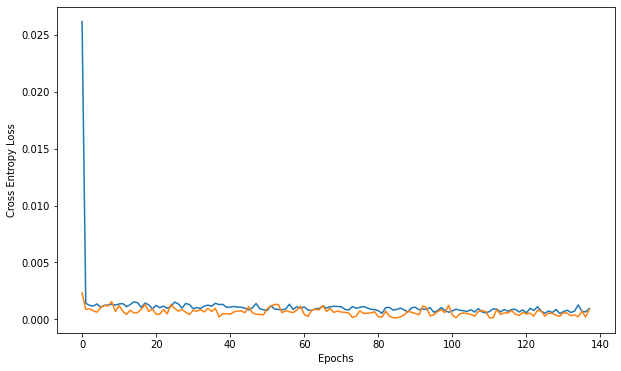

In [88]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(losses)), losses, label='Training loss')
plt.plot(np.arange(len(losses)), validation_losses, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

In [56]:
Counter(labels.cpu().numpy())

Counter({6: 378982,
         0: 33159,
         1: 44129,
         4: 9474,
         2: 8678,
         9: 12649,
         3: 518,
         8: 283,
         5: 449,
         7: 30})

In [42]:
set(labels.cpu().numpy())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [53]:
y_batch[75]

tensor(6, device='cuda:0')

In [1]:
label_scores[55]

NameError: name 'label_scores' is not defined

In [23]:
model = torch.load("FinalModelV2")
model.eval()

BiLSTM(
  (lstm1): LSTM(20, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
  (Sigmoid): ReLU()
)

In [51]:
def accuracy(labels, predicted):
    total_accuracy = 0
    n = len(predicted)
    for y, p in zip(labels, predicted):
        if (y == p):
            total_accuracy +=1
    return total_accuracy/n

In [38]:
v_test = torch.from_numpy(np.array(x_train, dtype=np.float64)).view(-1, 1, 20).float()
predicted = model(v_test)

In [43]:
y = []

for p in predicted:
    i = 0
    m = 0
    for index, e in enumerate(p):
        if float(e) > m:
            i = index
            m = e
    y.append(i+1)

In [50]:
Counter(y)

Counter({2: 27647,
         9: 60323,
         7: 21769,
         10: 48768,
         6: 78758,
         5: 64879,
         1: 70385,
         3: 33409,
         8: 54048,
         4: 28365})

In [52]:
acc = accuracy(y_test, y)
print(acc)

0.03611336927742546
